In [2]:
# Libraries Used

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import shap


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
data = pd.read_excel('Telecom_Customer_Dataset.xlsx')
data.head()

,Unnamed: 0,customer_id,tenure_months,monthly_charges,total_charges,internet_service,contract_type,payment_method,tech_support,senior_citizen,churn
0,0,1,52,43.362476,1029.644450,Fiber,Month-to-month,Electronic check,0,0,1
1,1,2,15,60.956093,1489.277262,Fiber,Month-to-month,Bank transfer,1,1,1
2,2,3,61,98.008402,6220.316387,DSL,Month-to-month,Debit card,0,0,1
3,3,4,21,97.122482,4159.473138,DSL,Month-to-month,Credit card,1,0,1
4,4,5,24,42.810038,183.480270,DSL,One year,Electronic check,0,0,0


In [10]:
# Data Cleaning & Preprocessing


# check missing
data.isnull().sum()

# encode categorical variables
data_encoded = pd.get_dummies(data, drop_first=True)

X = data_encoded.drop(["customer_id", "churn"], axis=1)
y = data_encoded["churn"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# Exploratory Data Analysis (EDA)

# 🔹 Churn Rate
churn_rate = data["churn"].mean()
print("Churn Rate:", churn_rate)

Churn Rate: 0.699625


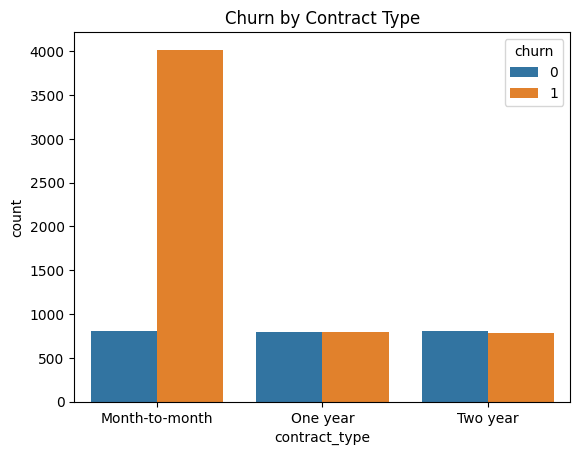

In [12]:
# Churn vs Contract Type

sns.countplot(data=data, x="contract_type", hue="churn")
plt.title("Churn by Contract Type")
plt.show()

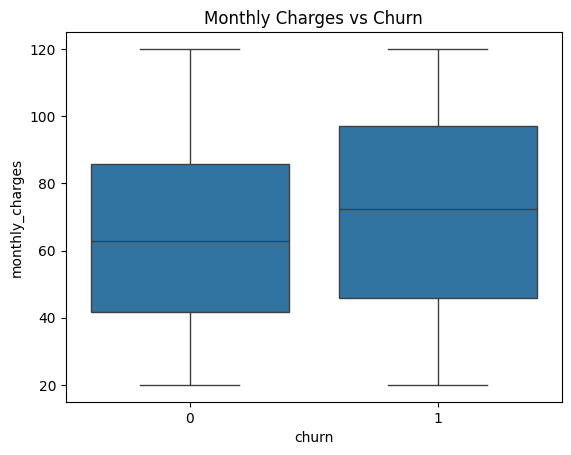

In [13]:
# Monthly Charges Distribution

sns.boxplot(data=data, x="churn", y="monthly_charges")
plt.title("Monthly Charges vs Churn")
plt.show()

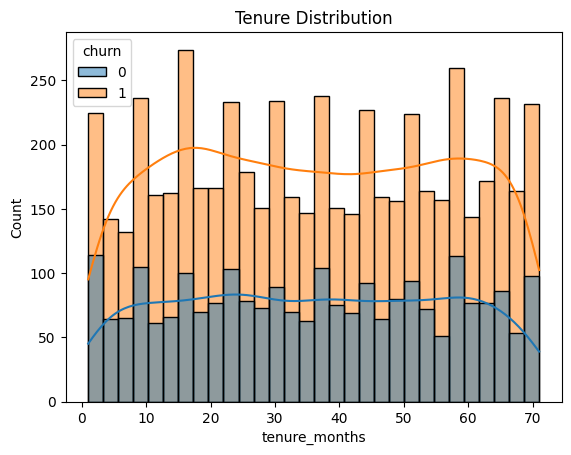

In [14]:
# Tenure Analysis

sns.histplot(data=data, x="tenure_months", hue="churn", bins=30, kde=True)
plt.title("Tenure Distribution")
plt.show()

In [15]:
# Machine Learning Models
# 🔹 Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

In [16]:
# Logistic Regression (Baseline)

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)

print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, log_model.predict_proba(X_test)[:,1]))

              precision    recall  f1-score   support

           0       0.63      0.49      0.56       601
           1       0.80      0.88      0.84      1399

    accuracy                           0.76      2000
   macro avg       0.72      0.69      0.70      2000
weighted avg       0.75      0.76      0.75      2000

ROC-AUC: 0.8136439267886856


In [17]:
# Random Forest (Main Model)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

              precision    recall  f1-score   support

           0       0.57      0.68      0.62       601
           1       0.85      0.78      0.81      1399

    accuracy                           0.75      2000
   macro avg       0.71      0.73      0.71      2000
weighted avg       0.76      0.75      0.75      2000

ROC-AUC: 0.809345634331154


In [37]:
# Reshaping the data for SHAP

data = pd.read_excel('Telecom_Customer_Dataset.xlsx')
data.head()

# check missing
data.isnull().sum()

# encode categorical variables
data_encoded = pd.get_dummies(data, drop_first=True)

X = data_encoded.drop(["customer_id", "churn"], axis=1)
y = data_encoded["churn"]

In [40]:
data.drop('Unnamed: 0',axis=1, inplace=True)

In [41]:
# Keep an unscaled copy for SHAP

# Before scaling, save the DataFrame:

X_df = data_encoded.drop(["customer_id", "churn"], axis=1)
y = data_encoded["churn"]

In [42]:
# Scale ONLY for model training

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

In [43]:
# Train Random Forest on scaled data

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",8
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_

In [44]:
# Create Pandas version of training data for SHAP

X_train_df = pd.DataFrame(X_train, columns=X_df.columns)

In [ ]:
import shap

explainer = shap.Explainer(rf, X_train_df)
shap_values = explainer(X_train_df)

100%|===================| 11959/12000 [04:31<00:00]        

C:\Users\HP\AppData\Local\Temp\ipykernel_15224\3452541732.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\plots\_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


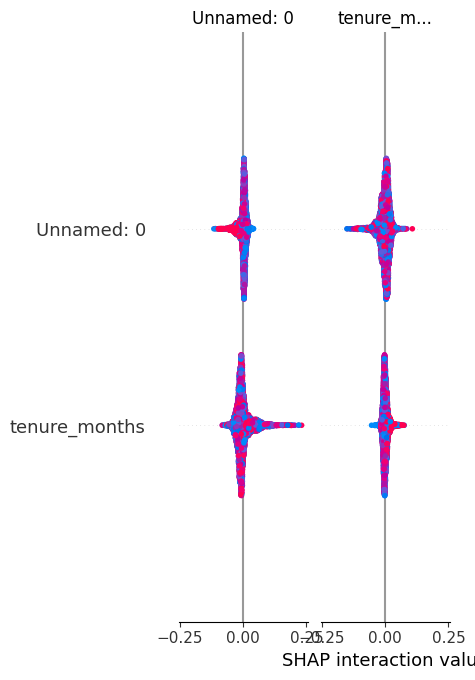

In [48]:
# Plot summary 
shap.summary_plot(
    shap_values.values,
    X_train_df,
    feature_names=X_train_df.columns
)

SHAP Summary Plot – Key Interpretations

1. The SHAP summary plot highlights the most influential features driving customer churn predictions across the dataset.

2. Tenure is the strongest factor: customers with short tenure have a significantly higher churn risk, while long-term customers are more stable.

3. High monthly charges consistently push predictions toward churn, indicating strong price sensitivity.

4. Contract type plays a critical role: month-to-month contracts increase churn likelihood, whereas long-term contracts reduce churn risk.

5. Technical support availability lowers churn probability, demonstrating its importance in customer retention.

6. Overall, churn is driven more by pricing, contract structure, and engagement factors than by customer demographics.